## Homework A - Graph Neural Networks ##

### Problem 1 - Cora Dataset ###

In [76]:
# Import packages
import os
import time as time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch_geometric.datasets import Planetoid

In [77]:
# define visualization function
def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().numpy())
    
    plt.figure(figsize=(6, 6))
    plt.scatter(z[:, 0], z[:, 1], s=30, c=color, cmap="Set2")
    plt.show()

Task a) Distribution of nodes

In [78]:
# Import dataset
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='/tmp/Cora', name='Cora', transform=NormalizeFeatures())
# View graph statistics
print()
print(f'Dataset name: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

graph = dataset[0] # Get the graph
print()
print(graph)

print('=============================================================================================================')
print(f'Number of nodes: {graph.num_nodes}')
print(f'Number of training nodes: {graph.train_mask.sum()}') 
print(f'Number of validation nodes: {graph.val_mask.sum()}')
print(f'Number of test nodes: {graph.test_mask.sum()}')



Dataset name: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of training nodes: 140
Number of validation nodes: 500
Number of test nodes: 1000


Task b) Train a standard dense network (supervised) and a convolution network (semi-supervised)

1. Dense Network: Multiple Layer Perceptron (MLP)

In [79]:
import torch
from torch.nn import Linear
import torch.nn.functional as F

class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(graph.num_features, hidden_channels) # Defines input layer
        self.lin2 = Linear(hidden_channels, dataset.num_classes) # Defines hidden layer, acts as a classifier
        
    def forward(self, x):
        x = self.lin1(x) # Applies input layer
        x = x.relu()     # Applies ReLU non-linearity
        x = F.dropout(x, p=0.5, training=self.training) # Applies dropout during training, randomly zeroing out 50% of the elements
        return self.lin2(x) # Applies hidden layer
    
model = MLP(hidden_channels=16) # 1433 input features, 16 output features (for each hidden node)
print(model)  

MLP(
  (lin1): Linear(in_features=1433, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=7, bias=True)
)


Visualize untrained MLP network results

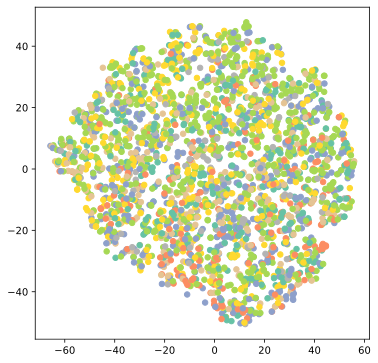

In [80]:
model.eval()
out = model(graph.x)
visualize(out, color=graph.y)

Train and evaluate the MLP network

In [81]:
# Train the network
criterion = torch.nn.CrossEntropyLoss() # Defines the loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4) # Defines the optimizer

def train():
    model.train()
    optimizer.zero_grad() # Clears existing gradients from previous epoch
    out = model(graph.x)   # Performs a single forward pass
    loss = criterion(out[graph.train_mask], graph.y[graph.train_mask]) # Computes the loss only for training nodes
    loss.backward() # Computes gradients
    optimizer.step() # Updates parameters based on current gradients
    return loss

def test():
    model.eval()
    out = model(graph.x)
    pred = out.argmax(dim=1) # Use the class with highest probability
    test_correct = pred[graph.test_mask] == graph.y[graph.test_mask] # Check against ground-truth labels
    test_acc = int(test_correct.sum()) / int(graph.test_mask.sum()) # Derive ratio of correct predictions
    
    return test_acc

# Train the model
for epoch in range(1, 201):
    loss = train()
    # print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
    
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.5900


Visualize

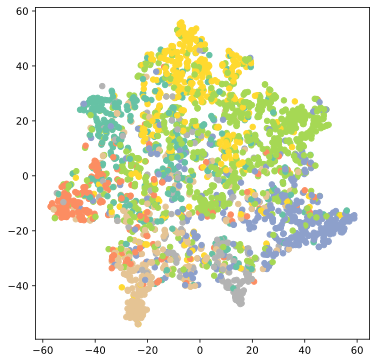

In [82]:
model.eval()
out = model(graph.x)
visualize(out, color=graph.y)

2. Graph Neural Network (GNN)

In [83]:
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(graph.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes) 
    
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        return self.conv2(x, edge_index)
    
model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


Visualize graph network when untrained

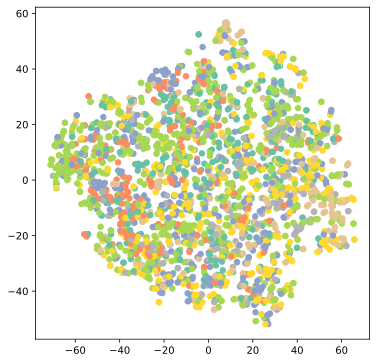

In [84]:
out = model(graph.x, graph.edge_index)
visualize(out, color=graph.y)

Train and evaluate GNN

In [85]:
# Train the network
criterion = torch.nn.CrossEntropyLoss() # Defines the loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4) # Defines the optimizer

def train():
    model.train()
    optimizer.zero_grad() # Clears existing gradients from previous epoch
    out = model(graph.x, graph.edge_index)   # Performs a single forward pass
    loss = criterion(out[graph.train_mask], graph.y[graph.train_mask]) # Computes the loss only for training nodes
    loss.backward() # Computes gradients
    optimizer.step() # Updates parameters based on current gradients
    return loss

def test():
    model.eval()
    out = model(graph.x, graph.edge_index)
    pred = out.argmax(dim=1) # Use the class with highest probability
    test_correct = pred[graph.test_mask] == graph.y[graph.test_mask] # Check against ground-truth labels
    test_acc = int(test_correct.sum()) / int(graph.test_mask.sum()) # Derive ratio of correct predictions
    
    return test_acc

for epoch in range(1, 101):
    loss = train()
    # print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8120


Visualize network after training

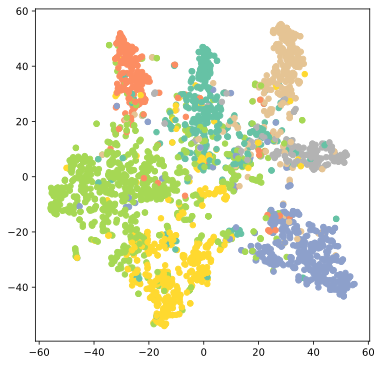

In [86]:
model.eval()

out = model(graph.x, graph.edge_index)
visualize(out, color=graph.y)

### Problem 2 - Quantum error correction

Starting Code:

In [87]:
# additional packages
from torch_geometric.loader import DataLoader
import torch_geometric.utils as utils
import networkx as nx
from torch_geometric.nn import global_mean_pool

%config InlineBackend.figure_format = 'svg'

Load dataset

In [88]:
dataset = torch.load('graph_data_decoding_2023.pt')

View properties of the dataset

In [89]:
print('====================')
print(f'Number of graphs: {len(dataset)}')
print('=================================================================================')
data = dataset[20]
print(f'Properties of one of the graphs: {data}')
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')
print(f'Number of node features: {data.num_node_features}')

Number of graphs: 1000000
Properties of one of the graphs: Data(x=[5, 4], edge_index=[2, 20], edge_attr=[20, 1], y=[1, 2])
Number of nodes: 5
Number of edges: 20
Average node degree: 4.00
Has isolated nodes: False
Has self-loops: False
Is undirected: True
Number of node features: 4


Label (y) representation:
- 00 -> class I
- 10 -> class X
- 01 -> class Z
- 11 -> class Y

In [90]:
label = data.y
print(label.shape)
label_X = label[:,0]
label_Z = label[:,1]
print('X: ', label_X, 'Z: ', label_Z)
print('-> class X')

torch.Size([1, 2])
X:  tensor([1.]) Z:  tensor([0.])
-> class X


4-dimensional feature vector for each **node**, scalar weight for each **edge**

In [91]:
edge_index = data.edge_index.t()
print('Edge indices [from, to]:')
print(edge_index)
edge_index = edge_index.numpy() # convert to numpy array
feature = data.x.numpy()
print('Feature vector:')
print(feature) 
edge = data.edge_attr.numpy()
print('edge weights:')
print(edge)

Edge indices [from, to]:
tensor([[0, 1],
        [0, 2],
        [0, 3],
        [0, 4],
        [1, 0],
        [1, 2],
        [1, 3],
        [1, 4],
        [2, 0],
        [2, 1],
        [2, 3],
        [2, 4],
        [3, 0],
        [3, 1],
        [3, 2],
        [3, 4],
        [4, 0],
        [4, 1],
        [4, 2],
        [4, 3]])
Feature vector:
[[1.  0.  0.  0.4]
 [0.  1.  0.2 0.4]
 [0.  1.  0.2 0.8]
 [1.  0.  0.4 0.4]
 [0.  1.  0.4 1. ]]
edge weights:
[[1.        ]
 [0.25      ]
 [0.25      ]
 [0.11111111]
 [1.        ]
 [0.25      ]
 [1.        ]
 [0.11111111]
 [0.25      ]
 [0.25      ]
 [0.25      ]
 [1.        ]
 [0.25      ]
 [1.        ]
 [0.25      ]
 [0.11111111]
 [0.11111111]
 [0.11111111]
 [1.        ]
 [0.11111111]]


Visualize example graph

(-0.04200000062584877,
 0.4420000065863133,
 0.3370000049471855,
 1.063000001013279)

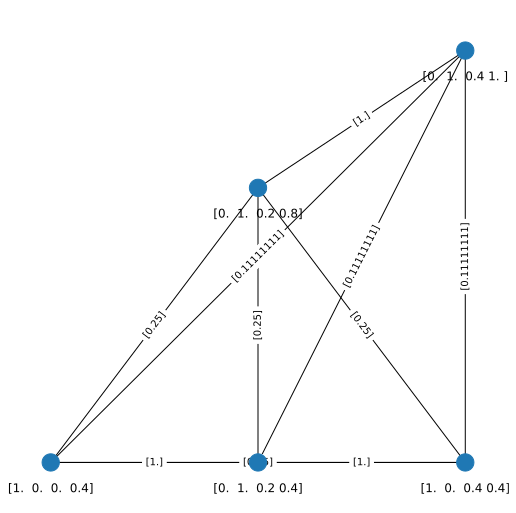

In [92]:
graph = dataset[20]
g = utils.to_networkx(graph, to_undirected=True)
positions = {}
label_positions = {}
node_labels = {}
edge_labels = {}
x = graph.x.numpy()

for i in range(x.shape[0]):
    positions[i] = np.array([x[i,2], x[i,3]])
    label_positions[i] = np.array([x[i,2], x[i,3]-0.03])
    node_labels[i] = np.array([x[i,0], x[i,1], x[i,2], x[i,3]])
for i in range(edge_index.shape[0]):
    edge_labels[(edge_index[i,0], edge_index[i,1])] = edge[i]
    
fig, ax = plt.subplots(figsize=(9,9))
nx.draw_networkx(g, pos=positions, ax=ax, labels=node_labels, with_labels=False)
nx.draw_networkx_labels(g, pos=label_positions, labels=node_labels, ax=ax, verticalalignment='top')
nx.draw_networkx_edge_labels(g, pos=positions, edge_labels=edge_labels, ax=ax)
ax.axis('off')

Split data into test and validation

In [93]:
num_samples = len(dataset)
print(f'Number of samples: {int(num_samples//1e6)}M')
train_data = dataset[int(0.05*num_samples):] # 95% training data
test_data = dataset[:int(0.05*num_samples)]  # 5% test data
train_loader = DataLoader(train_data, batch_size=1000, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1000, shuffle=True)

Number of samples: 1M


Construct and train a GNN

In [94]:
graph = test_data[0]
num_classes = 2
num_features = graph.num_node_features
# From colab example

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.conv4 = GCNConv(hidden_channels, hidden_channels)
        self.lin1 = Linear(hidden_channels, 32)
        self.lin2 = Linear(32, 32)
        self.lin3 = Linear(32, 16)
        self.lin4 = Linear(16, num_classes)

    def forward(self, x, edge_index, edge_attr, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index, edge_attr)
        x = leaky_relu(x)
        x = self.conv2(x, edge_index, edge_attr)
        x = leaky_relu(x)
        x = self.conv3(x, edge_index, edge_attr)
        x = leaky_relu(x)
        x = self.conv4(x, edge_index, edge_attr)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Dense network
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin1(x)
        x = self.lin2(x)
        x = self.lin3(x)
        x = self.lin4(x)
        
        return x

In [95]:
start_time = time.time()

model = GCN(hidden_channels=64)
print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = torch.nn.BCEWithLogitsLoss()

leaky_relu = torch.nn.LeakyReLU()
# leaky_relu = torch.nn.LeakyReLU(negative_slope=0.005)

def heaviside(x):
    return torch.where(x > 0, torch.tensor(1.0), torch.tensor(0.0))

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
         out = model(data.x, data.edge_index, data.edge_attr, data.batch)  # Perform a single forward pass.
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def test(loader):
     model.eval()

     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         out = model(data.x, data.edge_index, data.edge_attr, data.batch)  
         pred = heaviside(out)
         correct += torch.all(pred == data.y, dim=1).sum()  # Counts number of rows where both bits were predicted correctly.
     return correct / len(loader.dataset) 

train_acc_list = []
test_acc_list = []
for epoch in range(1, 31):
    train()
    
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    train_acc_list.append(train_acc.item())
    test_acc_list.append(test_acc.item())
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

stop_time = time.time()
print(f'Training time: {(stop_time-start_time)/60:.1f} minutes')

GCN(
  (conv1): GCNConv(4, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (conv4): GCNConv(64, 64)
  (lin1): Linear(in_features=64, out_features=32, bias=True)
  (lin2): Linear(in_features=32, out_features=32, bias=True)
  (lin3): Linear(in_features=32, out_features=16, bias=True)
  (lin4): Linear(in_features=16, out_features=2, bias=True)
)
Epoch: 001, Train Acc: 0.8944, Test Acc: 0.8952
Epoch: 002, Train Acc: 0.9145, Test Acc: 0.9145
Epoch: 003, Train Acc: 0.9232, Test Acc: 0.9222
Epoch: 004, Train Acc: 0.9268, Test Acc: 0.9259
Epoch: 005, Train Acc: 0.9290, Test Acc: 0.9284
Epoch: 006, Train Acc: 0.9327, Test Acc: 0.9312
Epoch: 007, Train Acc: 0.9327, Test Acc: 0.9313
Epoch: 008, Train Acc: 0.9346, Test Acc: 0.9342
Epoch: 009, Train Acc: 0.9397, Test Acc: 0.9400
Epoch: 010, Train Acc: 0.9418, Test Acc: 0.9403
Epoch: 011, Train Acc: 0.9335, Test Acc: 0.9317
Epoch: 012, Train Acc: 0.9430, Test Acc: 0.9433
Epoch: 013, Train Acc: 0.9437, Test Acc: 0.9434
Epoch: 014, Train A

Maximum test accuracy 95.17


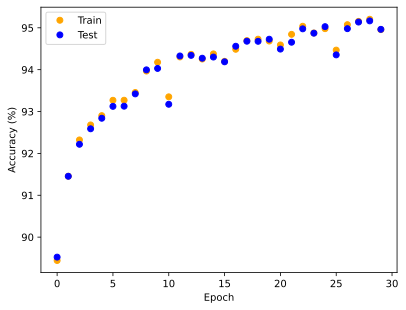

In [96]:
train_acc_list = [100*i for i in train_acc_list]
plt.plot(train_acc_list, 'o', label='Train', color='orange')

test_acc_list = [100*i for i in test_acc_list]
plt.plot(test_acc_list, 'o', label='Test', color='blue')

print(f"Maximum test accuracy {max(test_acc_list):.2f}")
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.savefig('accuracy.png', dpi=300)
plt.show()

GraphConv Network

In [97]:
from torch_geometric.nn import GraphConv

class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GNN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GraphConv(num_features, hidden_channels)
        self.conv2 = GraphConv(hidden_channels, hidden_channels)
        self.conv3 = GraphConv(hidden_channels, hidden_channels)
        self.conv4 = GraphConv(hidden_channels, hidden_channels)
        self.conv5 = GraphConv(hidden_channels, hidden_channels)
        self.conv6 = GraphConv(hidden_channels, hidden_channels)
        
        self.lin1 = Linear(hidden_channels, 32)
        self.lin2 = Linear(32, 32)
        self.lin3 = Linear(32, 16)
        self.lin4 = Linear(16, 16)
        self.lin4 = Linear(16, num_classes)
    
    def forward(self, x, edge_index, edge_attr, batch):
        x = self.conv1(x, edge_index, edge_attr)
        x = leaky_relu(x)
        x = self.conv2(x, edge_index, edge_attr)
        x = leaky_relu(x)
        x = self.conv3(x, edge_index, edge_attr)
        x = leaky_relu(x)
        x = self.conv4(x, edge_index, edge_attr)
        x = leaky_relu(x)
        x = self.conv5(x, edge_index, edge_attr)
        x = leaky_relu(x)
        x = self.conv6(x, edge_index, edge_attr)
        
        x = global_mean_pool(x, batch)
        
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.lin1(x)
        x = self.lin2(x)
        x = self.lin3(x)
        x = self.lin4(x)
        
        return x

model = GNN(hidden_channels=64)
print(model)

GNN(
  (conv1): GraphConv(4, 64)
  (conv2): GraphConv(64, 64)
  (conv3): GraphConv(64, 64)
  (conv4): GraphConv(64, 64)
  (conv5): GraphConv(64, 64)
  (conv6): GraphConv(64, 64)
  (lin1): Linear(in_features=64, out_features=32, bias=True)
  (lin2): Linear(in_features=32, out_features=32, bias=True)
  (lin3): Linear(in_features=32, out_features=16, bias=True)
  (lin4): Linear(in_features=16, out_features=2, bias=True)
)


In [98]:
start_time = time.time()
model = GNN(hidden_channels=64)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = torch.nn.BCEWithLogitsLoss()

leaky_relu = torch.nn.LeakyReLU()
# leaky_relu = torch.nn.LeakyReLU(negative_slope=0.005)

def heaviside(x):
    return torch.where(x > 0, torch.tensor(1.0), torch.tensor(0.0))

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
         out = model(data.x, data.edge_index, data.edge_attr, data.batch)  # Perform a single forward pass.
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def test(loader):
     model.eval()

     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         out = model(data.x, data.edge_index, data.edge_attr, data.batch)  
         pred = heaviside(out)
         correct += torch.all(pred == data.y, dim=1).sum()  # Counts number of rows where both bits were predicted correctly.
     return correct / len(loader.dataset) 

train_acc_list = []
test_acc_list = []
for epoch in range(1, 21):
    train()
    
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    train_acc_list.append(train_acc.item())
    test_acc_list.append(test_acc.item())
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
    
stop_time = time.time()
print(f'Training time: {(stop_time-start_time)/60:.1f} minutes')

Epoch: 001, Train Acc: 0.9669, Test Acc: 0.9670
Epoch: 002, Train Acc: 0.9696, Test Acc: 0.9698
Epoch: 003, Train Acc: 0.9735, Test Acc: 0.9730
Epoch: 004, Train Acc: 0.9746, Test Acc: 0.9748
Epoch: 005, Train Acc: 0.9758, Test Acc: 0.9759
Epoch: 006, Train Acc: 0.9765, Test Acc: 0.9769
Epoch: 007, Train Acc: 0.9778, Test Acc: 0.9780
Epoch: 008, Train Acc: 0.9779, Test Acc: 0.9780
Epoch: 009, Train Acc: 0.9794, Test Acc: 0.9789
Epoch: 010, Train Acc: 0.9792, Test Acc: 0.9788
Epoch: 011, Train Acc: 0.9797, Test Acc: 0.9799
Epoch: 012, Train Acc: 0.9801, Test Acc: 0.9796
Epoch: 013, Train Acc: 0.9800, Test Acc: 0.9794
Epoch: 014, Train Acc: 0.9798, Test Acc: 0.9795
Epoch: 015, Train Acc: 0.9807, Test Acc: 0.9806
Epoch: 016, Train Acc: 0.9798, Test Acc: 0.9797
Epoch: 017, Train Acc: 0.9814, Test Acc: 0.9807
Epoch: 018, Train Acc: 0.9812, Test Acc: 0.9809
Epoch: 019, Train Acc: 0.9810, Test Acc: 0.9807
Epoch: 020, Train Acc: 0.9813, Test Acc: 0.9808
Training time: 23.7 minutes


Maximum test accuracy 98.09


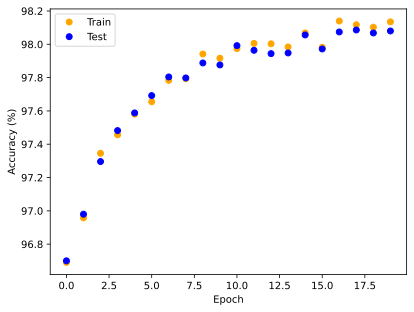

In [99]:
train_acc_list = [100*i for i in train_acc_list]
plt.plot(train_acc_list, 'o', label='Train', color='orange')

test_acc_list = [100*i for i in test_acc_list]
plt.plot(test_acc_list, 'o', label='Test', color='blue')


print(f"Maximum test accuracy {max(test_acc_list):.2f}")
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.savefig('accuracy_GraphConv.png', dpi=300)
plt.show()